# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Update

This notebook now uses `sklearn.ensemble.HistGradientBoostingClassifier`.

## Imports and Settings

In [1]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

# from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay

from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '/workspace'))
from utils import format_time

In [3]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [4]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [7]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [8]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [9]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [10]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [11]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [12]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         358914 non-null  float64
 7   SMB            358914 non-null  float64
 8   HML            358914 non-null  float64
 9   RMW            358914 non-null  float64
 10  CMA            358914 non-null  float64
 11  momentum_2     358914 non-null  float64
 12  momentum_3     358914 non-null  float64
 13  momentum_6     358914 non-null  float64
 14  momentum_9     358914 non-null  float64
 15  momentum_12    358914 non-null  float64
 16  

In [13]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [56]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [57]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [58]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [59]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [60]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [61]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [62]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [25]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [26]:
algo = 'dummy_clf'

In [27]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [28]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.503582,0.500008
Accuracy,0.503582,0.500008
F1,0.516424,0.504660
Log Loss,-17.814285,-17.855239
Precision,0.548116,0.504698
Recall,0.505758,0.504622


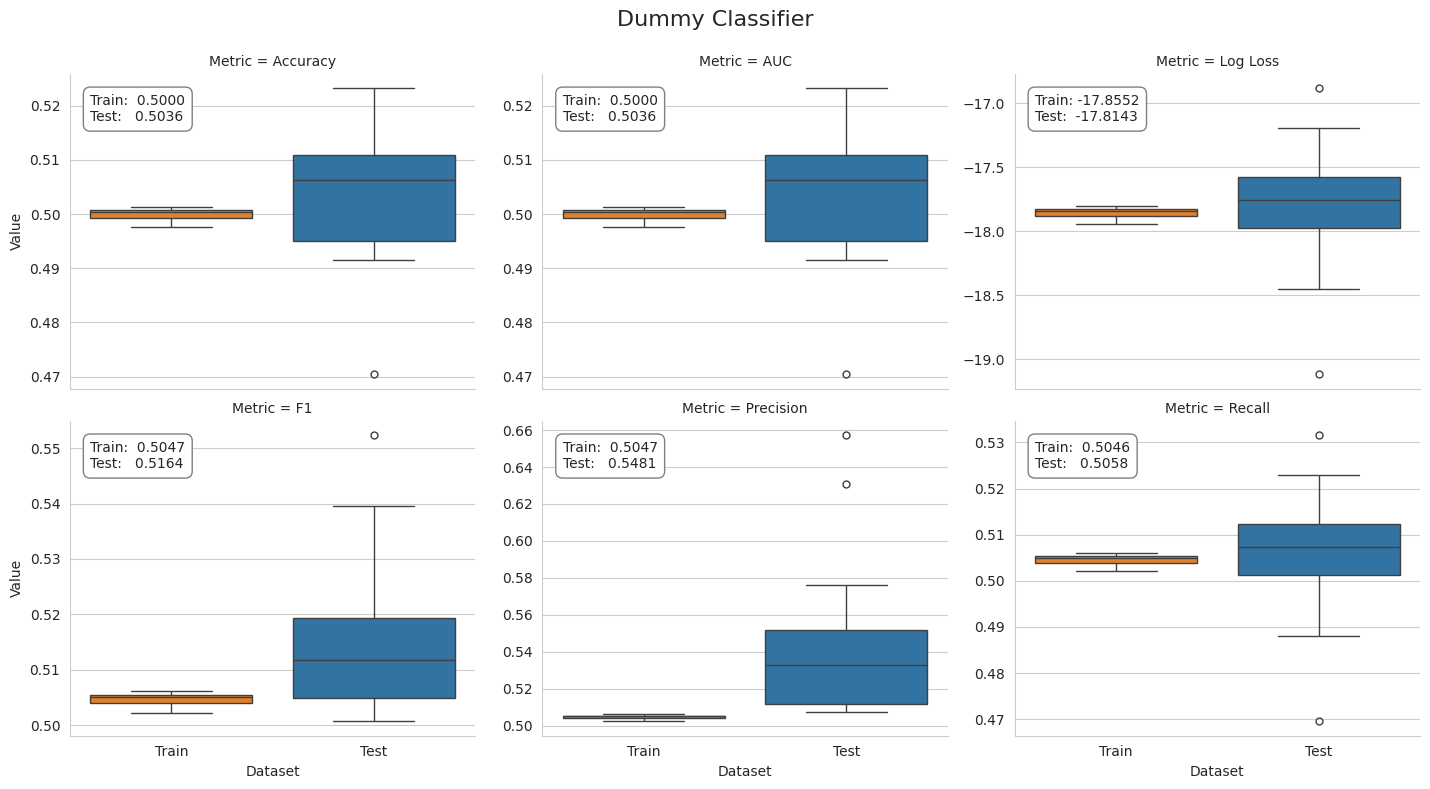

In [29]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [31]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='sqrt',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [32]:
algo = 'random_forest'

In [33]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min fini

### Plot Results

In [34]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.529432,1.000000
Accuracy,0.518883,0.999999
F1,0.512963,0.999999
Log Loss,-0.691680,-0.169345
Precision,0.570337,0.999999
Recall,0.544614,0.999999


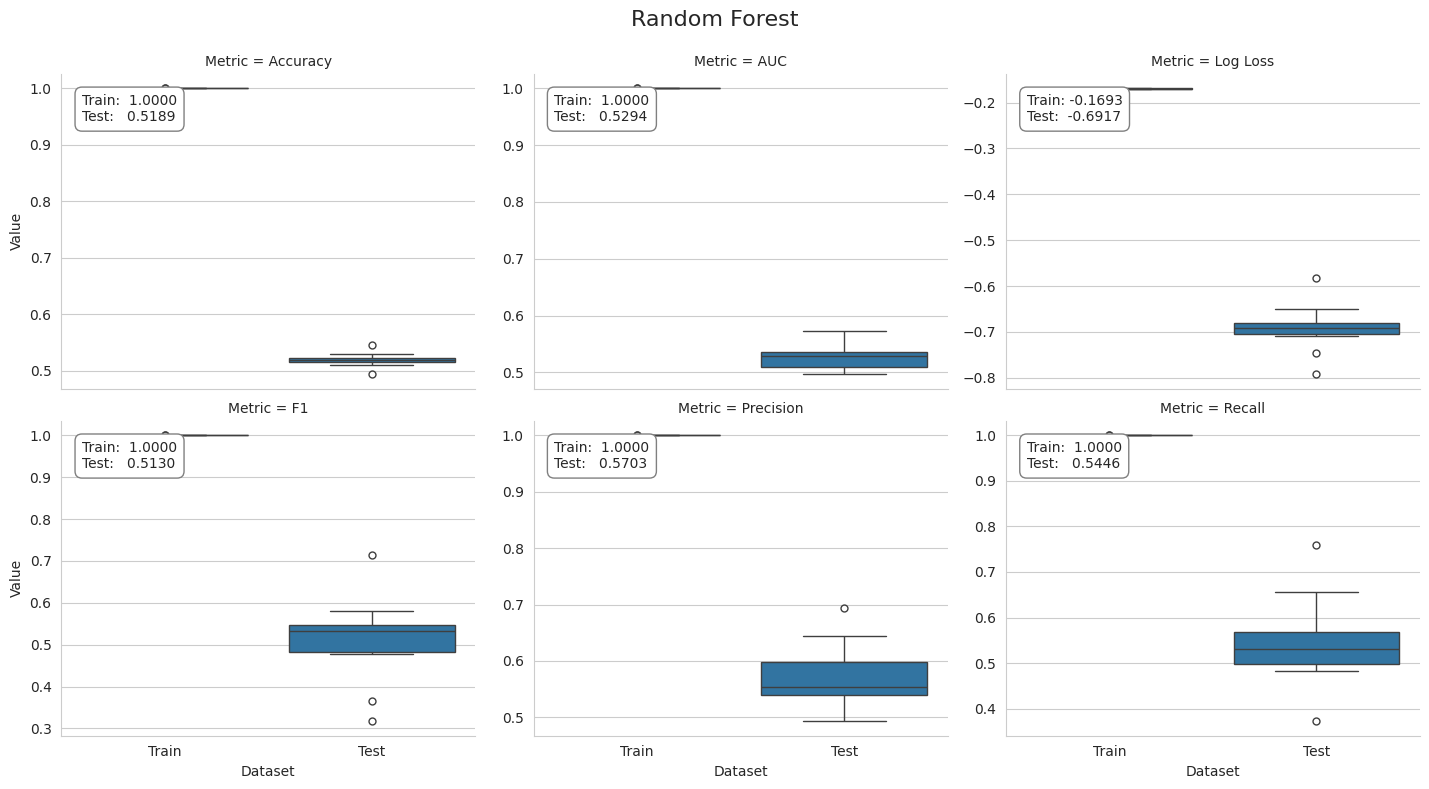

In [35]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [39]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [41]:
ada_clf = AdaBoostClassifier(estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [42]:
algo = 'adaboost'

In [43]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

### Plot Result

In [44]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.537245,0.608146
Accuracy,0.506668,0.569204
F1,0.465470,0.571025
Log Loss,-0.692845,-0.692696
Precision,0.550032,0.583504
Recall,0.572769,0.588108


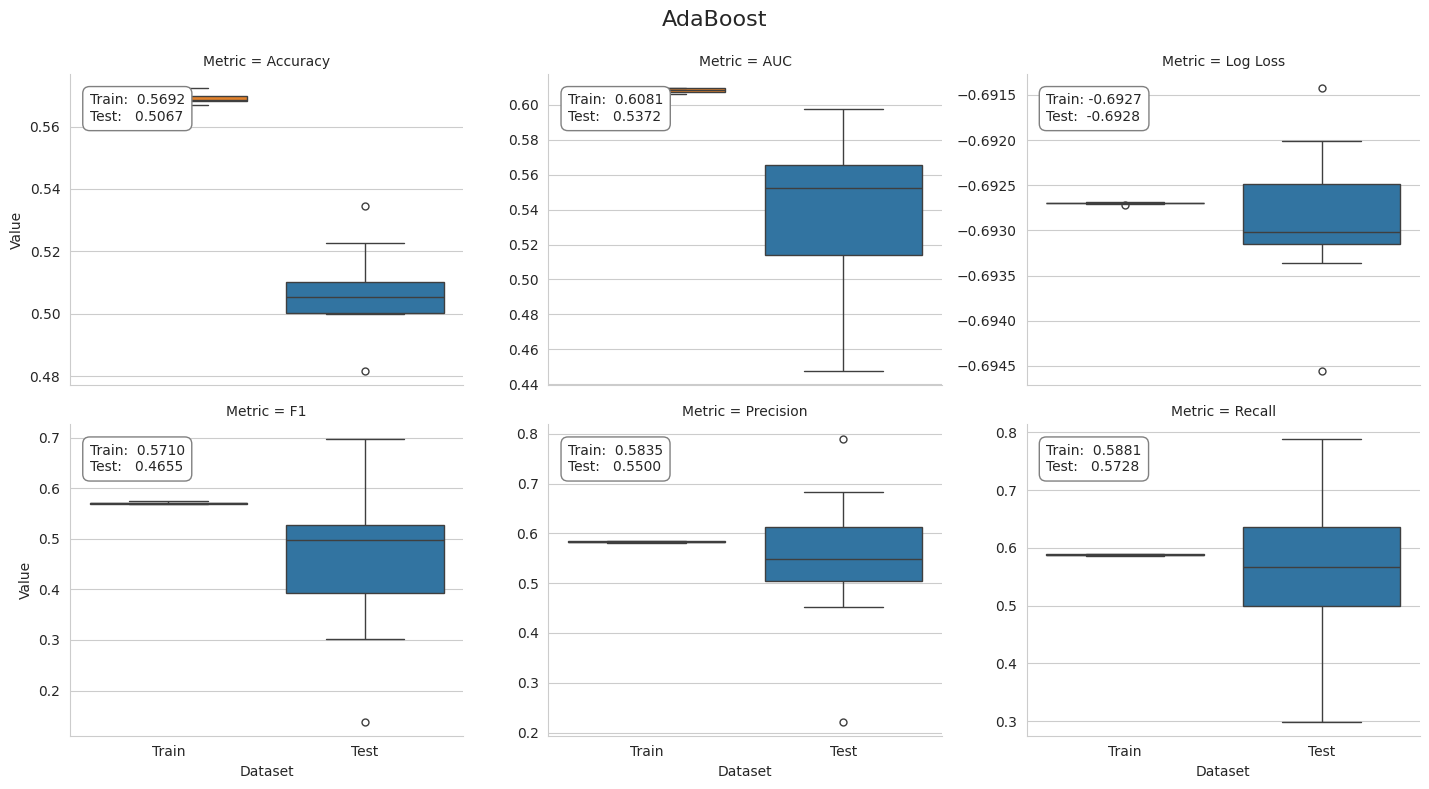

In [45]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: HistGradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

This estimator is much faster than [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [21]:
gb_clf = HistGradientBoostingClassifier(loss='log_loss',              
                                        learning_rate=0.1,          # regulates the contribution of each tree
                                        max_iter=100,               # number of boosting stages
                                        min_samples_leaf=20,
                                        max_depth=None,
                                        random_state=None,
                                        max_leaf_nodes=31,           # opt value depends on feature interaction
                                        warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0,
                                        tol=0.0001)

### Cross-validate

In [22]:
algo = 'sklearn_gbm'

In [23]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

### Plot Results

In [24]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.537896,0.749152
Accuracy,0.507746,0.675252
F1,0.450094,0.681442
Log Loss,-0.694476,-0.595833
Precision,0.562474,0.692767
Recall,0.553273,0.689309


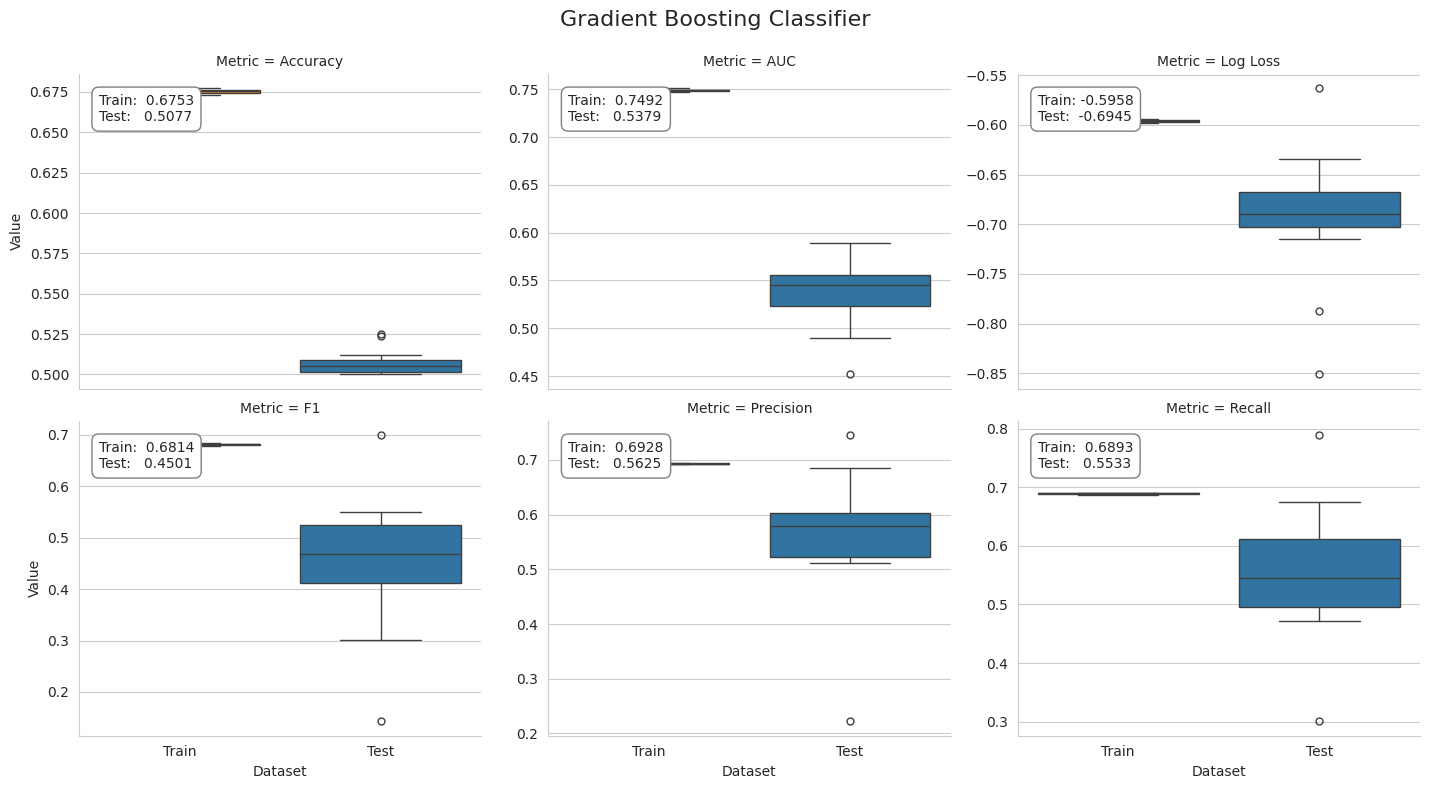

In [25]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [26]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [27]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [28]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.585287547151385

In [29]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.610637722038409

#### One-way and two-way partial depende plots

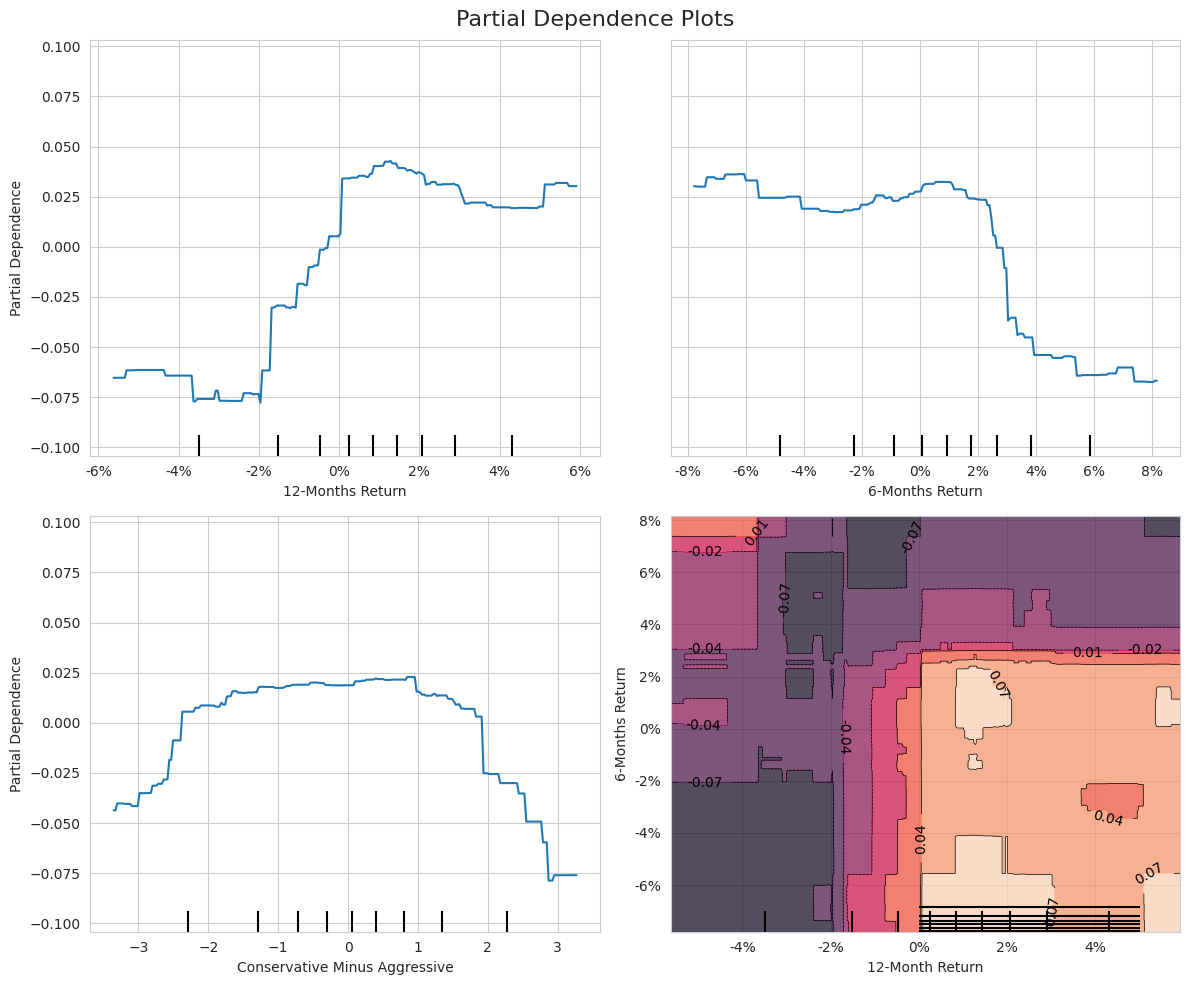

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# plot_partial_dependence(
PartialDependenceDisplay.from_estimator(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    # n_cols=2,
    # response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)


#### Two-way partial dependence as 3D plot

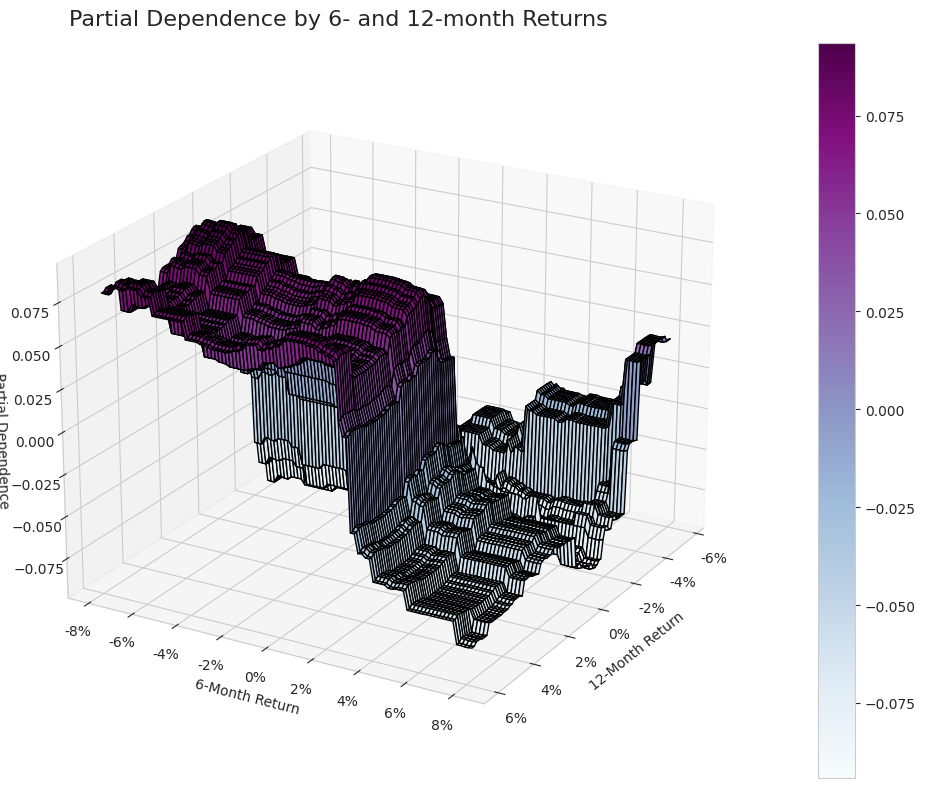

In [31]:
from sklearn.inspection import partial_dependence

targets = ['return_12m', 'return_6m']

# Calculate partial dependence
pd_results = partial_dependence(
    gb_clf, X_, features=targets, kind="average", grid_resolution=100
)

# Extract the values
xx, yy = np.meshgrid(pd_results["grid_values"][0], pd_results["grid_values"][1])
Z = pd_results.average[0].T

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(xx, yy, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')

ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()
plt.show()

## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [32]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [33]:
algo = 'xgboost'

In [34]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:35:37] WARNING: /workspace/src/learner.cc:

### Plot Results

In [35]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.518894,0.684444
Accuracy,0.500394,0.617600
F1,0.388768,0.620717
Log Loss,-0.704891,-0.644044
Precision,0.540026,0.639847
Recall,0.492066,0.636616


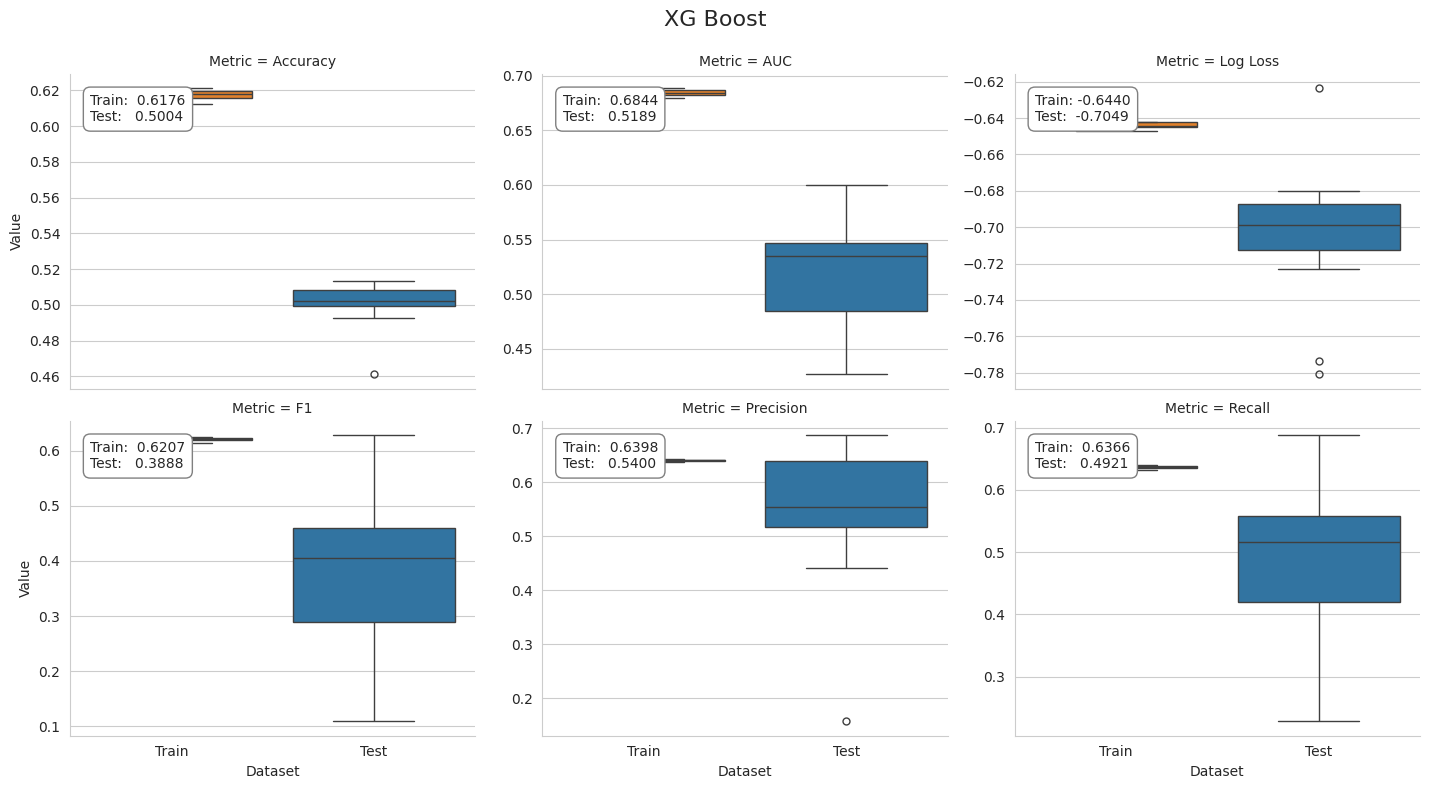

In [37]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

### Feature Importance

In [38]:
xgb_clf.fit(X=X_dummies, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [39]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

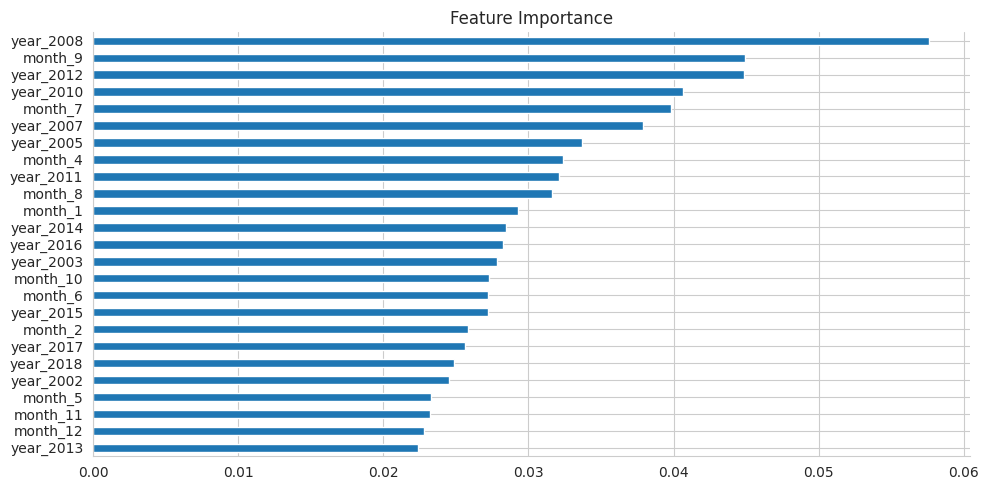

In [40]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [41]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [42]:
algo = 'lgb_factors'

In [45]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] 
Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] [LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecut

/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.1min finished


##### Plot Results

In [46]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.523149,0.750082
Accuracy,0.505040,0.677064
F1,0.408443,0.683419
Log Loss,-0.728450,-0.592609
Precision,0.547411,0.691273
Recall,0.485174,0.689660


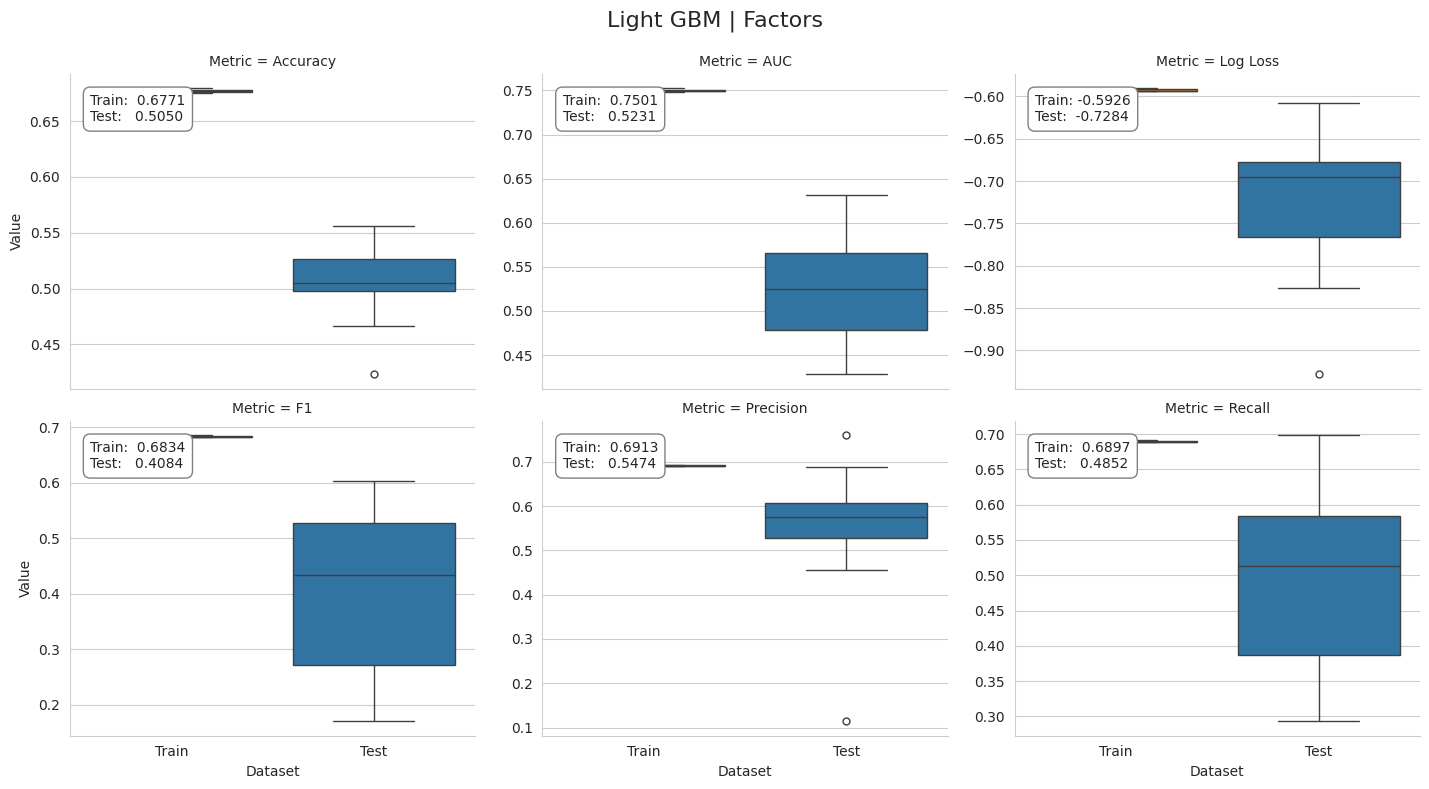

In [47]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [48]:
algo = 'lgb_dummies'

In [49]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 195408, number of negative: 161668
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 193157, number of negative: 158405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5985
[LightGBM] [Info] Number of data points in the train set: 357076, number of used features: 83
[LightGBM] [Info] [binary:Bo

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.7min finished


##### Plot results

In [50]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.525503,0.743774
Accuracy,0.510838,0.670296
F1,0.431022,0.676395
Log Loss,-0.704090,-0.600406
Precision,0.549003,0.688925
Recall,0.506892,0.685068


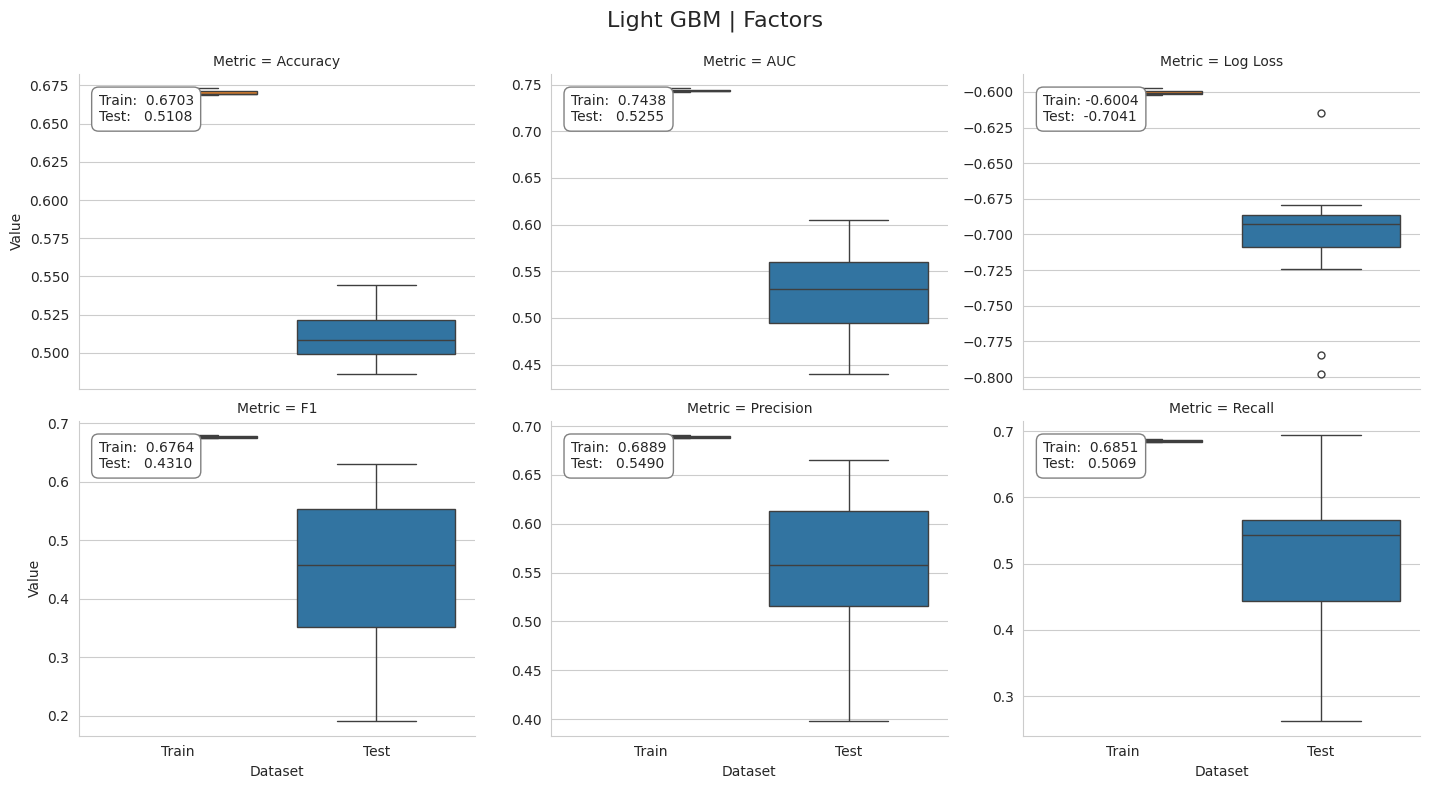

In [51]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [52]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [65]:
for col in cat_cols:
    X_factors[col] = X_factors[col].astype(str)

s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

Catboost requires integer values for categorical variables.

In [54]:
algo = 'catboost'

In [66]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_factors,
                                           fit_params=fit_params,
                                           n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Learning rate set to 0.126754
0:	learn: 0.6728320	total: 318ms	remaining: 5m 17s
Learning rate set to 0.126475
1:	learn: 0.6574056	total: 482ms	remaining: 4m
2:	learn: 0.6457044	total: 658ms	remaining: 3m 38s
Learning rate set to 0.126195
3:	learn: 0.6373654	total: 872ms	remaining: 3m 37s
0:	learn: 0.6734810	total: 419ms	remaining: 6m 59s
4:	learn: 0.6307113	total: 1.1s	remaining: 3m 38s
1:	learn: 0.6581748	total: 639ms	remaining: 5m 18s
2:	learn: 0.6465206	total: 835ms	remaining: 4m 37s
5:	learn: 0.6254384	total: 1.38s	remaining: 3m 48s
0:	learn: 0.6729561	total: 467ms	remaining: 7m 46s
3:	learn: 0.6381995	total: 1.16s	remaining: 4m 49s
1:	learn: 0.6577782	total: 833ms	remaining: 6m 55s
6:	learn: 0.6216718	total: 1.8s	remaining: 4m 15s
Learning rate set to 0.125915
4:	learn: 0.6313539	total: 1.55s	remaining: 5m 8s
2:	learn: 0.6459816	total: 1.27s	remaining: 7m 1s
7:	learn: 0.6185593	total: 2.29s	remaining: 4m 43s
5:	learn: 0.6259948	total: 1.85s	remaining: 5m 7s
0:	learn: 0.6730274	to

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 24.2min finished


#### Plot Results

In [67]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.535166,0.801762
Accuracy,0.530142,0.720353
F1,0.533256,0.726218
Log Loss,-0.690733,-0.539479
Precision,0.580963,0.729155
Recall,0.551913,0.728917


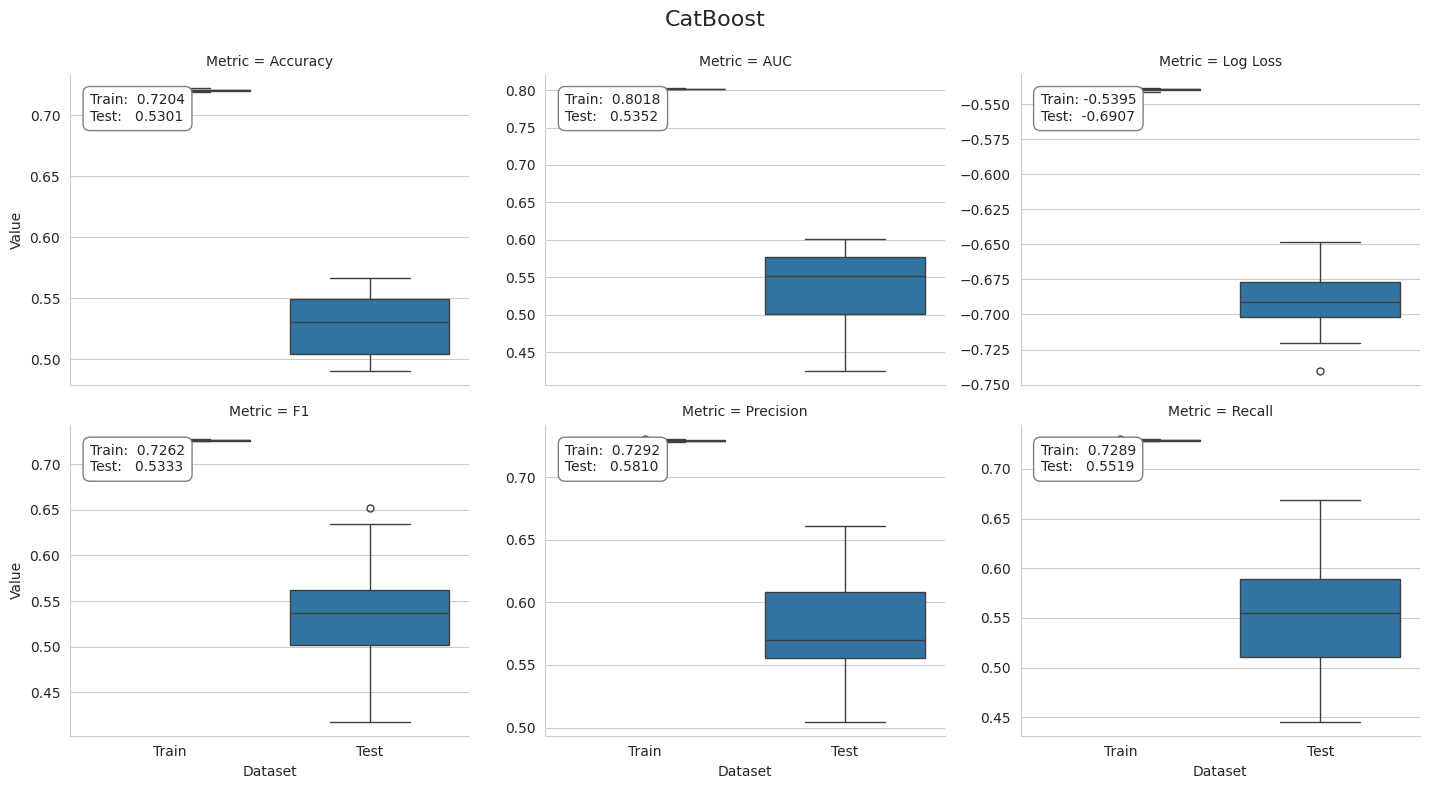

In [68]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

> Naturally, the following requires that you have a GPU.

#### Configure

In [ ]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [ ]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [ ]:
algo = 'catboost_gpu'

In [ ]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               y=y,
                                               X=X_factors,
                                               fit_params=fit_params, 
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

#### Plot Results

In [ ]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

In [ ]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [ ]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

In [ ]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [ ]:
print(run_time)

In [ ]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [ ]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [ ]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
# auc = auc[auc.Model != 'Baseline']

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC',
            data=auc,
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout()